In [1]:
#Import the required libraries into Python to use for this modelling exercise.
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

#This line ensures that the graphs are displayed in-line within Jupyter. 
%matplotlib inline

#Set the parameters for the graph to be displayed. 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

In [3]:
#Read the MELSYD passenger data, imported as a CSV file.
dataset = pd.read_csv("MELSYD.csv")

#Change the 'Month' column to a datetime format.
from datetime import datetime
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format=True)

#Set 'Month' as the index, name the new indexed dataset as 'MELSYD' 
MELSYD = dataset.set_index(['Month'])

In [4]:
#Show the first five rows of data, to test that the passenger data has been imported correctly.
MELSYD.head(5)

,#Passengers
Month,
2014-07-01,700207
2014-08-01,707012
2014-09-01,688231
2014-10-01,761619
2014-11-01,734701


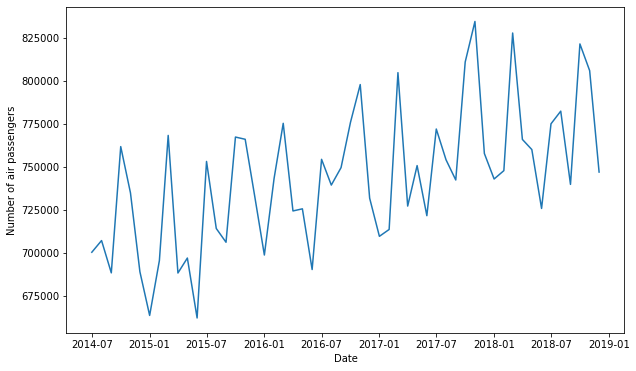

In [5]:
#Label the x & y axis, the plot the graph.
plt.xlabel("Date")
plt.ylabel("Number of air passengers")

#Plot the graph below.
plt.plot(MELSYD)

In [6]:
#Calculate the rolling average and rolling standard deviation to prepare for forecasting.
rollingavg = MELSYD.rolling(window=12).mean()
rollingstd = MELSYD.rolling(window=12).std()

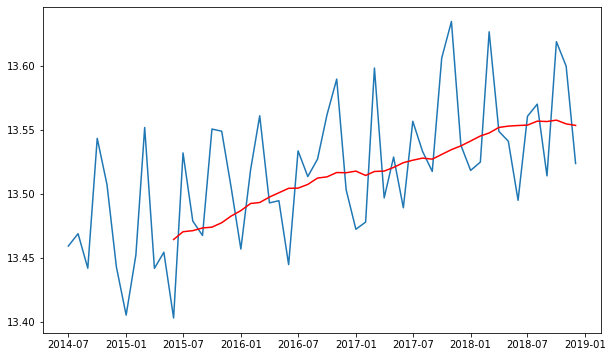

In [7]:
#Note: Why are we doing a log transformation?
#Note: The log transformation can be used to make highly skewed distributions less skewed.
#Note: This is useful for making patterns in the data more interpretable. 

#Convert the y-axis scale to log.
MELSYD_logScale = np.log(MELSYD)

#Calculate the moving average and moving standard deviation. 
movingAverage = MELSYD_logScale.rolling(window=12).mean()
movingSTD = MELSYD_logScale.rolling(window=12).std()

#Plot the moving average and moving standard deviation. 
plt.plot(MELSYD_logScale)
plt.plot(movingAverage, color='red') 

In [8]:
#Minus the 'moving average' for stationarity purposes.
#Stationarity is a particular behaviour over time that is likely to recur. 
MELSYD_logScale_minusMA = MELSYD_logScale - movingAverage

#Drop the NaN values (remove the blank values)
MELSYD_logScale_minusMA.dropna(inplace=True)

In [9]:
#Create a function ("test_for_stationarity") that determines the rolling statistics, plots the rolling statistics, and performs a Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller
def test_for_stationarity(timeseries):
    
    #Determine rolling average and rolling standard deviation
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot the rolling average and rolling standard deviation
    original = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Average')
    std = plt.plot(movingSTD, color='black', label = 'Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Average & Standard Deviation')
    plt.show(block=False)

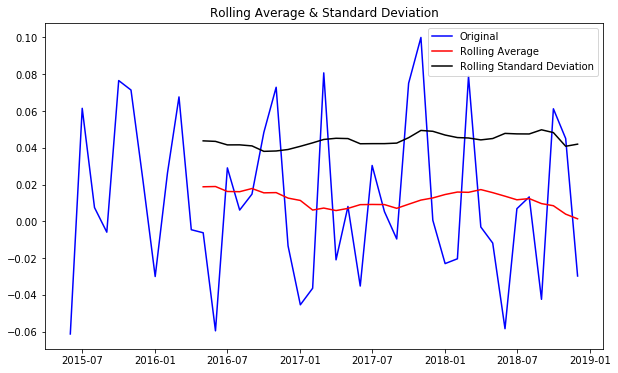

In [10]:
#Test the MELSYD Log-scaled minus moving average data in the 'test_for_stationarity' function defined above.
test_for_stationarity(MELSYD_logScale_minusMA)

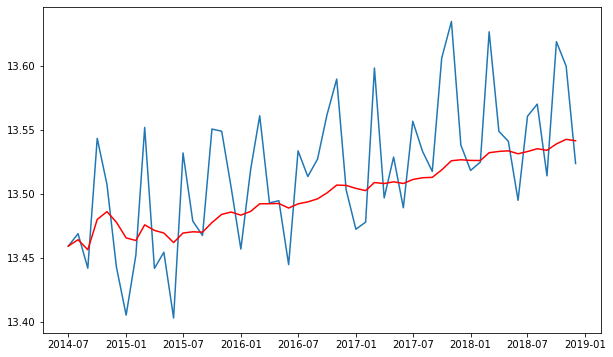

In [11]:
#Calculate the exponential decay weighted average of the time series to observe trend within the time series.
MELSYDWeightedAverage = MELSYD_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()

#Plot the exponential decay weighted average of the time series to observe trend within the time series.
plt.plot(MELSYD_logScale)
plt.plot(MELSYDWeightedAverage, color='red')

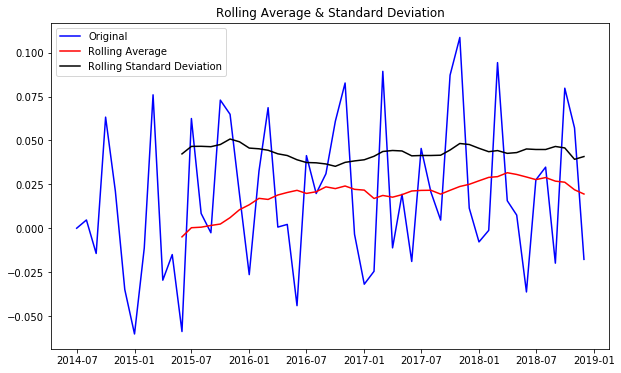

In [12]:
#Minus the weighted average from the log scale
MELSYD_log_minus_WA = MELSYD_logScale - MELSYDWeightedAverage
test_for_stationarity(MELSYD_log_minus_WA)

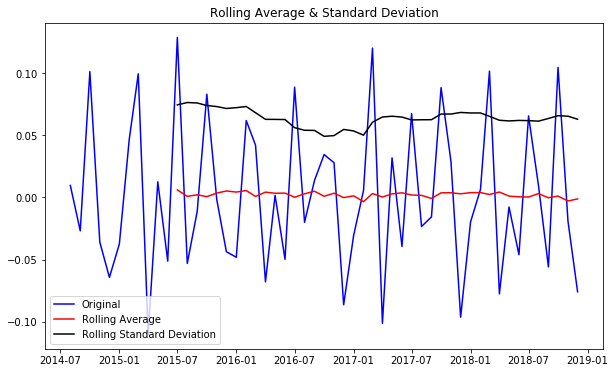

Results of Dickey-Fuller Test:
Test Statistic                -7.429358e+00
p-value                        6.421493e-11
#Lags Used                     1.000000e+01
Number of Observations Used    4.200000e+01
Critical Value (1%)           -3.596636e+00
Critical Value (5%)           -2.933297e+00
Critical Value (10%)          -2.604991e+00
dtype: float64


In [13]:
#Shift values into time series so we can use them for forecasting
MELSYDLogDiffShift = MELSYD_logScale - MELSYD_logScale.shift()
MELSYDLogDiffShift.dropna(inplace=True)
test_for_stationarity(MELSYDLogDiffShift)

#Perform Dickey-Fuller test:
#Note: What is a Dickey-Fuller test? It is a test for stationarity (we want to minimise unpredictable results)
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(MELSYDLogDiffShift['#Passengers'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items(): dfoutput['Critical Value (%s)'%key] = value

#Print the output of the Dickey-Fuller test: 
print(dfoutput)

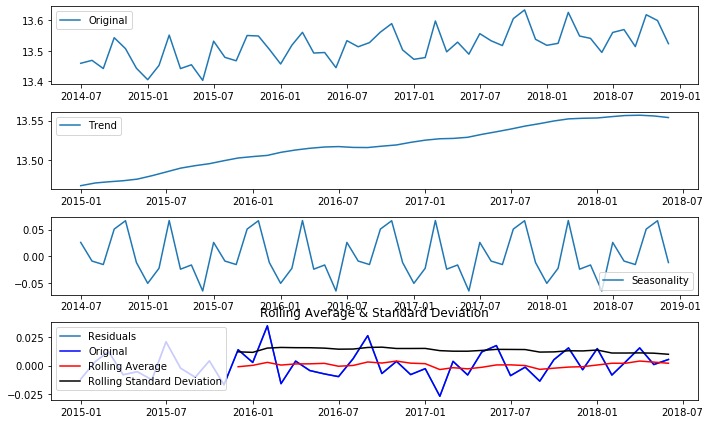

In [14]:
#Plot the original graph.
#Plot the linear trend.
#Plot the seasonality graph.
#Plot the rolling average and the rolling standard deviation to test for stationarity.

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(MELSYD_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(MELSYD_logScale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

decomposedLogData = residual
decomposedLogData.dropna(inplace=True)

#Test for stationarity
test_for_stationarity(decomposedLogData)

/srv/conda/envs/notebook/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so infe

Text(0.5, 1.0, 'RSS: 0.0733')

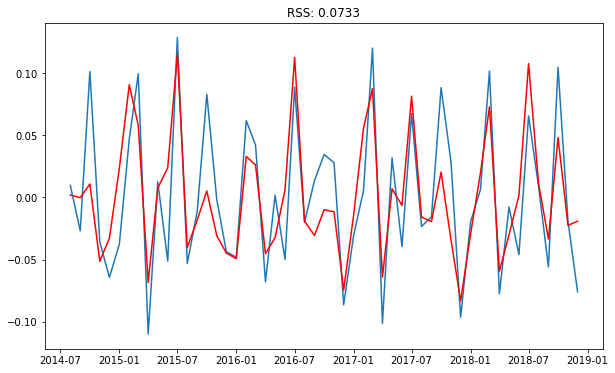

In [15]:
#Apply the ARIMA Model - aim for a low RSS result.
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(MELSYD_logScale, order=(3, 1, 3))
results_ARIMA = model.fit(disp=-1)

#Plot the ARIMA Model - aim for a low RSS result.
plt.plot(MELSYDLogDiffShift)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-MELSYDLogDiffShift["#Passengers"])**2))

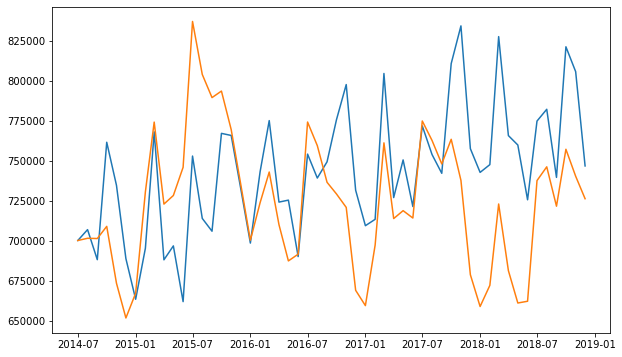

In [16]:
#Apply the required mathematical transformations. 
#Convert into a time-series format.
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

#Convert into a cumulative sum.
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

#Apply log.
predictions_ARIMA_log = pd.Series(MELSYD_logScale['#Passengers'].iloc[0], index=MELSYD_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

#Apply anti-log (exp) for plotting. 
predictions_ARIMA= np.exp(predictions_ARIMA_log)
plt.plot(MELSYD)
plt.plot(predictions_ARIMA)

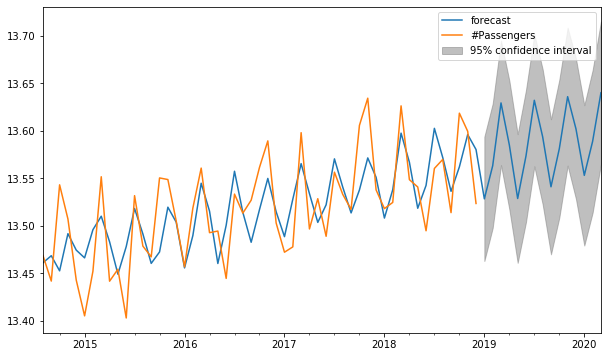

In [17]:
#Forecast the future growth of passengers using the ARIMA model. 
#Forecast for 12 months in the future - hence, 12 steps forward. 
results_ARIMA.plot_predict(1,68)
x=results_ARIMA.forecast(steps=12)

In [18]:
#Convert log results back to passenger number results using anti-log.
results = results_ARIMA.forecast(steps=12)    
converted_results = [(np.exp(x)) for x in [i for i in results]]
print(converted_results)

[array([750454.19891865, 777033.11033375, 830199.58873477, 794278.41082735,
       750740.61671407, 785129.86680973, 832505.48379333, 801142.76186137,
       760055.89126851, 791143.25670047, 835684.39613657, 807834.66540291]), array([1.03393961, 1.03395754, 1.03398176, 1.0351489 , 1.03515291,
       1.03609443, 1.03609576, 1.036944  , 1.03694466, 1.03770855,
       1.03770874, 1.03839606]), array([[702933.39445354, 801187.57924774],
       [727804.52332043, 829591.51146842],
       [777566.95078085, 886394.87113391],
       [742279.99780355, 849919.43171475],
       [701587.14423785, 803337.80088928],
       [732418.57189767, 841634.73102481],
       [776611.57960546, 892422.15638615],
       [746156.77334896, 860180.79284084],
       [707888.99556854, 816067.15384521],
       [735779.9309136 , 850672.36319621],
       [777203.84811209, 898565.30129458],
       [750328.65517456, 869747.99926147]])]
